# Market Data Outlier Detection

This notebook implements various methods for detecting outliers in market data, including statistical methods, machine learning models, and an evaluation of LLM-based anomaly detection. The dataset focuses on 10-year treasury yields from the FRED API.

## 1. Import Required Libraries

We will import libraries for data manipulation, visualization, and machine learning.

In [39]:
# conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from scipy import stats
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import holidays
import random
from dotenv import load_dotenv
import os
load_dotenv()

True

## 2. Load and Preprocess Data

Load the data from the FRED API, filter it by date, and handle missing values.

In [40]:
# Load data from FRED API
API_KEY=os.getenv("API_KEY")
fred = Fred(api_key=API_KEY)
series = {'DGS10': '10Y'}  # 10-Year Treasury Yield
df = pd.DataFrame({name: fred.get_series(code) for code, name in series.items()})
df.index = pd.to_datetime(df.index)
df = df[df.index >= '2002-01-01']  # Filter data from 2002 onwards

## 3. Detect Missing Data

Identify missing data, distinguish between expected (holidays) and unexpected missing data, and annotate the dataset.

In [41]:
# Detect missing data
years = range(df.index.min().year, df.index.max().year + 1)
us_holidays = pd.to_datetime(list(holidays.US(years=years).keys()))
is_holiday = pd.Series(df.index.isin(us_holidays), index=df.index)

mask_missing_any = df.isna().any(axis=1)
mask_unexpected = mask_missing_any & (~is_holiday)

df['missing_reason'] = ''
df.loc[is_holiday, 'missing_reason'] = 'holiday'
df.loc[mask_unexpected, 'missing_reason'] = 'Unexpected Missing'

print("Missing Data Summary:")
print(df['missing_reason'].value_counts())

df = df.drop(columns=['missing_reason'])
df = df.dropna()

Missing Data Summary:
missing_reason
                      5955
holiday                242
Unexpected Missing      21
Name: count, dtype: int64


## 4. Visualize Data Distribution

Plot the distribution of the 10Y rates to understand the data's characteristics.

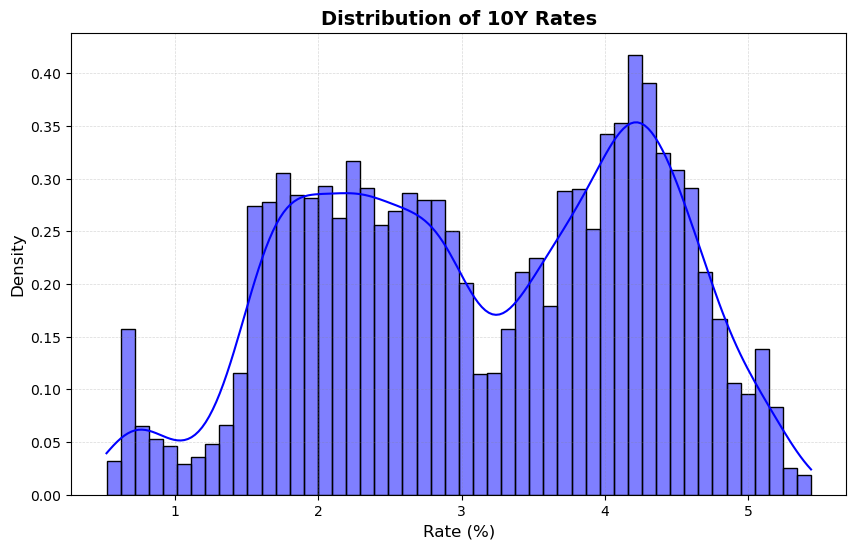

In [42]:
# Visualize data distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['10Y'].dropna(), bins=50, kde=True, color='blue', stat='density')
plt.title('Distribution of 10Y Rates', fontsize=14, weight="bold")
plt.xlabel('Rate (%)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.show()

## 5. Detect Stale Rates

Identify stale rates by checking for consecutive days with no changes in the data.

In [43]:
# Detect stale rates
stale = (df['10Y'].diff().abs() < 1e-8).astype(int).rolling(5).sum()
stale_mask = (stale > 3)
print("Stale Rates Detected:")
print(stale[stale > 3].dropna().head())

Stale Rates Detected:
2005-01-10    4.0
2005-01-11    4.0
2006-12-20    4.0
2006-12-21    4.0
2021-01-04    4.0
Name: 10Y, dtype: float64


## 6. Inject Synthetic Outliers

Introduce synthetic spike outliers into the dataset to test the effectiveness of anomaly detection methods to identify this type of outliers.

In [44]:
## 6. Inject Synthetic Outliers

# Introduce synthetic spike outliers into the dataset to test the effectiveness of anomaly detection methods to identify this type of outliers.

df['outlier'] = 0
outlier_indices = np.random.choice(df.index, size=10, replace=False)
sd = np.std(df['10Y'])
df.loc[outlier_indices, '10Y_original'] = df.loc[outlier_indices, '10Y']
df.loc[outlier_indices, '10Y'] += random.choice([-1, 1]) * random.uniform(1, 3) * sd
df.loc[outlier_indices, 'outlier'] = 1

# Small outliers: simulate missing actual rate, by keeping only the fractional part of the rate
outlier_indices_small = np.random.choice(df.index, size=10, replace=False)
df.loc[outlier_indices_small, '10Y'] = df.loc[outlier_indices_small, '10Y'] - df.loc[outlier_indices_small, '10Y'].astype(int)
df.loc[outlier_indices_small, 'outlier'] = 1

print("Injected Outliers at:")
print(df.loc[outlier_indices])
print(df.loc[outlier_indices_small])

Injected Outliers at:
                 10Y  outlier  10Y_original
2021-11-23 -1.233974        1          1.67
2003-10-30  1.456026        1          4.36
2009-02-04  0.046026        1          2.95
2005-11-28  1.506026        1          4.41
2019-12-05 -1.103974        1          1.80
2021-03-17 -1.273974        1          1.63
2024-12-31  1.676026        1          4.58
2023-07-13  0.856026        1          3.76
2006-03-20  1.756026        1          4.66
2017-02-16 -0.453974        1          2.45
             10Y  outlier  10Y_original
2019-04-17  0.59        1           NaN
2011-11-02  0.03        1           NaN
2004-08-27  0.23        1           NaN
2020-07-01  0.69        1           NaN
2002-04-09  0.22        1           NaN
2019-02-12  0.68        1           NaN
2024-12-18  0.50        1           NaN
2025-10-21  0.98        1           NaN
2016-12-06  0.39        1           NaN
2015-05-07  0.18        1           NaN


## 7. Apply Statistical Methods for Outlier Detection

Implement Z-Score, IQR, Modified Z-Score, Grubbs Test, and Rule-Based methods in separate cells for easy testing.

In [45]:
# Z-Score Method
def z_score_method(series, threshold=3):
    z = (series - series.mean()) / series.std()
    return (np.abs(z) > threshold).astype(int)

df['z_score_preds'] = z_score_method(df['10Y'])

In [46]:
# IQR Method
def iqr_method(series, factor=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - factor * iqr, q3 + factor * iqr
    return ((series < lower) | (series > upper)).astype(int)

df['iqr_preds'] = iqr_method(df['10Y'])

In [47]:
# Modified Z-Score Method
def modified_z_score(series, threshold=3.5):
    median = series.median()
    mad = np.median(np.abs(series - median))
    mz = 0.6745 * (series - median) / mad
    return (np.abs(mz) > threshold).astype(int)

df['modified_z_score_preds'] = modified_z_score(df['10Y'])

In [48]:
# Rule-Based Method
def rule_based(series, change_threshold=0.1):
    pct_change = series.pct_change().fillna(0)
    return (np.abs(pct_change) > change_threshold).astype(int)
df['rule_based_preds'] = rule_based(df['10Y'])

In [49]:
# Evaluate methods
def evaluate_method(preds, labels):
    tp = ((preds == 1) & (labels == 1)).sum()
    fp = ((preds == 1) & (labels == 0)).sum()
    fn = ((preds == 0) & (labels == 1)).sum()
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    return tp, fp, fn, precision, recall, f1

methods = ['z_score_preds', 'iqr_preds', 'modified_z_score_preds', 'rule_based_preds']
results = {method: evaluate_method(df[method], df['outlier']) for method in methods}


# Print summary of overlaps
print("\n" + "="*80)
print("Simple statistical methods produce mediocre results on spike outliers")
print("="*80)
total_injected = len(df[df['outlier'] == 1])
print(f"Total Injected Outliers: {total_injected}")
print("-" * 80)

# Print results in markdown table
print("| **Method**               | **TP** | **FP** | **FN** | **Precision** | **Recall** | **F1 Score** |")
print("|--------------------------|--------|--------|--------|---------------|------------|--------------|")
for method, (tp, fp, fn, precision, recall, f1) in results.items():
    print(f"| {method.replace('_', ' ').title():<24} | {tp:<6} | {fp:<6} | {fn:<6} | {precision:.2f}          | {recall:.2f}       | {f1:.2f}         |")


Simple statistical methods produce mediocre results on spike outliers
Total Injected Outliers: 20
--------------------------------------------------------------------------------
| **Method**               | **TP** | **FP** | **FN** | **Precision** | **Recall** | **F1 Score** |
|--------------------------|--------|--------|--------|---------------|------------|--------------|
| Z Score Preds            | 4      | 0      | 16     | 1.00          | 0.20       | 0.33         |
| Iqr Preds                | 3      | 0      | 17     | 1.00          | 0.15       | 0.26         |
| Modified Z Score Preds   | 0      | 0      | 20     | 0.00          | 0.00       | 0.00         |
| Rule Based Preds         | 19     | 48     | 1      | 0.28          | 0.95       | 0.44         |


Short summary of why plain methods fail

LOF / IsolationForest assume i.i.d. points and distance-based differences. In a time series a spike can be normal in the global distribution but anomalous relative to recent history.
Univariate detectors see only value magnitude, not context (recent pattern, slope, volatility). You need features that capture local context (lags, residuals, windows, embeddings), or detectors that operate on windows instead of single points. 

A more advanced data science approach is the Local Outlier Factor. The LOF looks to see if the data point deviates signifantly from the other data points. Note that by itself, this measure also has no awareness of the concept of time. By adding the sliding window to the LOF (Local Outlier Factor) we can soft of eliminate these short comings. It is important to test and set the window size correctly. Even though it worked great in my example the LOF approach may not work great for all datasets.

In [50]:
# LOF on sliding windows
window_size = 10  # lenght of each sliding window
n_neighbors = 16  # smoother density lowers FPs

# Build sliding windows: shape (n_windows, seq_len)
Xw = np.array([
    df['10Y'][i:i+window_size] 
    for i in range(len(df['10Y']) - window_size + 1)
])

# Estimate the contamination factor alpha
# By clipping the alpha estimate to a max value we still use an estimation of the contamination, not a true unsupervised value
def estimate_alpha_from_windows(Xw, c=4.0, min_alpha=1e-4, max_alpha=0.03):
    med = np.median(Xw, axis=1, keepdims=True)
    mad = np.median(np.abs(Xw - med), axis=1, keepdims=True) + 1e-8
    dev = np.max(np.abs(Xw - med) / mad, axis=1)  # max robust z per window
    flags = (dev > c).astype(int)
    alpha_est = flags.mean()
    alpha_est = np.clip(flags.mean(), min_alpha, max_alpha)
    return float(alpha_est), flags

alpha, robust_flags = estimate_alpha_from_windows(Xw, c=4.0)
print(f"Estimated contamination alpha={alpha:.6f} from robust window test (flagged_windows={robust_flags.sum()})")

# Fit LOF (raw windows, no scaling) with estimated contamination
lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=alpha)
win_pred = (lof.fit_predict(Xw) == -1).astype(int)   # 1 = outlier window
print(f"LOF flagged windows: {win_pred.sum()} (alpha={alpha:.6f})")

# Map window anomalies to point-level anomalies:
candidate_points = []
for i, flag in enumerate(win_pred):
    if flag == 1:
        window = Xw[i]
        rel = np.abs(window - np.median(window))
        idx_in_window = int(np.argmax(rel))
        candidate_points.append(i + idx_in_window)

# Add point
point_preds = np.zeros(len(df['10Y']), dtype=int)
for gidx in candidate_points:
    point_preds[gidx] = 1

df['lof_windowed_preds'] = point_preds

# Evaluate (labels used only here)
tn, fp, fn, tp = confusion_matrix(df['outlier'], df['lof_windowed_preds'] , labels=[0,1]).ravel()
precision = tp / (tp + fp + 1e-12)
recall = tp / (tp + fn + 1e-12)
f1 = 2 * precision * recall / (precision + recall + 1e-12)
print(f"LOF (windowed, unsupervised; alpha_est + persistence) -> TP={tp}, FP={fp}, FN={fn}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")



Estimated contamination alpha=0.030000 from robust window test (flagged_windows=1458)
LOF flagged windows: 179 (alpha=0.030000)
LOF (windowed, unsupervised; alpha_est + persistence) -> TP=19, FP=0, FN=1, Precision=1.000, Recall=0.950, F1=0.974


In [51]:
print(df)

             10Y  outlier  10Y_original  z_score_preds  iqr_preds  \
2002-01-02  5.20        0           NaN              0          0   
2002-01-03  5.16        0           NaN              0          0   
2002-01-04  5.18        0           NaN              0          0   
2002-01-07  5.09        0           NaN              0          0   
2002-01-08  5.10        0           NaN              0          0   
...          ...      ...           ...            ...        ...   
2025-10-24  4.02        0           NaN              0          0   
2025-10-27  4.01        0           NaN              0          0   
2025-10-28  3.99        0           NaN              0          0   
2025-10-29  4.08        0           NaN              0          0   
2025-10-30  4.11        0           NaN              0          0   

            modified_z_score_preds  rule_based_preds  lof_windowed_preds  
2002-01-02                       0                 0                   0  
2002-01-03           

# 11. GARCH
GARCH (Generalized Autoregressive Conditional Heteroskedasticity) is a statistical model used to estimate time-varying volatility in financial time series. Unlike simpler methods that assume constant variance, GARCH captures the tendency of financial markets to experience clustered periods of high and low volatility. In this notebook, we use a GARCH(1,1) model to estimate the expected variability of daily returns and flag points as anomalies when the observed deviations are unusually large compared to the predicted volatility.

In [52]:
from arch import arch_model
returns = df['10Y'].pct_change().dropna() 

model = arch_model(returns, vol='GARCH', p=1, q=1, mean='Constant', dist='normal')
garch_model = arch_model(returns, p=1, q=1, mean='Zero', vol='Garch', dist='normal')
garch_res = garch_model.fit(disp='off')  # fit quietly

resid = garch_res.resid   # model residuals
cond_vol = garch_res.conditional_volatility  # conditional std dev (volatility)
std_resid = resid / cond_vol
outlier_flags = (abs(std_resid) > 3).astype(int)
df['garch_preds'] = 0  # initialize with 0
df.loc[outlier_flags.index, 'garch_preds'] = outlier_flags  # assign flags where available


# Evaluate (labels used only here)
tn, fp, fn, tp = confusion_matrix(df['outlier'], df['garch_preds'], labels=[0, 1]).ravel()
precision = tp / (tp + fp + 1e-12)
recall    = tp / (tp + fn + 1e-12)
f1        = 2 * precision * recall / (precision + recall + 1e-12)
print(f"GARCH(1,1) -> TP={tp}, FP={fp}, FN={fn}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

GARCH(1,1) -> TP=19, FP=12, FN=1, Precision=0.613, Recall=0.950, F1=0.745


## 11 Train an LSTM autoencoder - with Windowing

Train a LSTM AutoEncoder, with windowed method to compare results.

In [53]:
# Optimized LSTM Autoencoder - Simplified and More Effective

# 1) Build sliding windows: shape (n_windows, seq_len) - same as LOF
window_size = 10
series = df['10Y'].values.astype(np.float32)
Xw = np.array([series[i:i+window_size] for i in range(len(series) - window_size + 1)])

# 2) Use same alpha estimation as LOF for consistency
def estimate_alpha_from_windows(Xw, c=4.0, min_alpha=1e-4, max_alpha=0.03):
    med = np.median(Xw, axis=1, keepdims=True)
    mad = np.median(np.abs(Xw - med), axis=1, keepdims=True) + 1e-8
    dev = np.max(np.abs(Xw - med) / mad, axis=1)
    flags = (dev > c).astype(int)
    alpha_est = np.clip(flags.mean(), min_alpha, max_alpha)
    return float(alpha_est), flags

alpha, robust_flags = estimate_alpha_from_windows(Xw, c=4.0)
print(f"Estimated contamination alpha={alpha:.6f} from robust window test (flagged_windows={robust_flags.sum()})")

# 3) Global normalization (preserves relative differences between windows)
global_mean = np.mean(Xw)
global_std = np.std(Xw)
Xw_normalized = (Xw - global_mean) / (global_std + 1e-8)

# 4) Simplified LSTM Autoencoder Model
class SimpleLSTMAE(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Encoder
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Decoder - simpler approach
        self.decoder = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        # Encode
        _, (hidden, _) = self.encoder(x)
        
        # Use only the last hidden state for reconstruction
        last_hidden = hidden[-1]  # Shape: (batch_size, hidden_size)
        
        # Simple linear decoder
        output = self.decoder(last_hidden)  # Shape: (batch_size, input_size)
        
        # Repeat for each timestep
        output = output.unsqueeze(1).repeat(1, x.size(1), 1)
        
        return output

# 5) Train LSTM Autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleLSTMAE(input_size=1, hidden_size=16, num_layers=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Higher learning rate
criterion = nn.MSELoss()

# Prepare data
Xw_tensor = torch.from_numpy(Xw_normalized).unsqueeze(-1).float().to(device)
dataset = TensorDataset(Xw_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)  # Larger batch size

# Training loop 
model.train()
epochs = 20  
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        x = batch[0]
        optimizer.zero_grad()
        
        reconstructed = model(x)
        loss = criterion(reconstructed, x)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if (epoch + 1) % 5 == 0:
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

# 6) Detect anomalous windows using reconstruction error
model.eval()
with torch.no_grad():
    Xw_tensor = torch.from_numpy(Xw_normalized).unsqueeze(-1).float().to(device)
    reconstructed = model(Xw_tensor)
    
    # Use max error instead of mean (more sensitive to spikes)
    reconstruction_errors = ((Xw_tensor - reconstructed) ** 2) \
    .view(Xw_tensor.size(0), -1) \
    .max(dim=1)[0] \
    .cpu().numpy()


# 7) Flag anomalous windows using estimated alpha
threshold = np.quantile(reconstruction_errors, 1 - alpha)
win_pred = (reconstruction_errors > threshold).astype(int)
print(f"LSTM AE flagged windows: {win_pred.sum()} (alpha={alpha:.6f})")

# 8) Map window anomalies to point-level anomalies (same as LOF)
candidate_points = []
for i, flag in enumerate(win_pred):
    if flag == 1:
        window = Xw[i]
        rel = np.abs(window - np.median(window))
        idx_in_window = int(np.argmax(rel))
        candidate_points.append(i + idx_in_window)

# 9) Create point predictions
point_preds = np.zeros(len(df['10Y']), dtype=int)
for gidx in candidate_points:
    point_preds[gidx] = 1

# 10) Persist and evaluate
df['lstm_windowed_preds'] = point_preds

tn, fp, fn, tp = confusion_matrix(df['outlier'], df['lstm_windowed_preds'], labels=[0,1]).ravel()
precision = tp / (tp + fp + 1e-12)
recall = tp / (tp + fn + 1e-12)
f1 = 2 * precision * recall / (precision + recall + 1e-12)
print(f"LSTM AE (optimized) -> TP={tp}, FP={fp}, FN={fn}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")



Estimated contamination alpha=0.030000 from robust window test (flagged_windows=1517)
Epoch 5/20, Loss: 0.022301
Epoch 10/20, Loss: 0.022424
Epoch 15/20, Loss: 0.022306
Epoch 20/20, Loss: 0.039855
LSTM AE flagged windows: 179 (alpha=0.030000)
LSTM AE (optimized) -> TP=19, FP=0, FN=1, Precision=1.000, Recall=0.950, F1=0.974


# IBM Time Series Foundation Model TSPulse 

BM has open-source code and granite-tsfm utilities (notebooks, tutorials, a “cookbook”) for working with the Granite family (TTM, TSPulse, FlowState). The repo + tutorials show how to run inference, and TSPulse is documented for anomaly detection tasks (including example code that outputs anomaly_score arrays). The granite repo and IBM docs are the practical place to get inference helpers.

Integration note: these models are available via Hugging Face model cards, but they are not (necessarily) usable through vanilla transformers semantics for text models — IBM provides a granite-tsfm package, notebooks and helper code for inference. So: use the granite TSFM utilities (pip install from the repo) and/or pull weights from Hugging Face and use the provided inference utilities. In short: they are available, but you should use the granite toolset / notebooks for smooth inference.

Use TSPulse (recommended for AD): TSPulse is small, explicitly benchmarked for anomaly detection (TSB-AD benchmarks) and has cookbook / tutorial examples showing anomaly scores and thresholds.

Window is analogous to the sliding context length — TSPulse internally handles how it slices sequences. If you previously implemented manual sliding windows for LSTM/LOF, you’ll find TSPulse accepts the sequence and returns anomaly scores without you needing to manually window every prediction (but you still choose context length).

https://www.ibm.com/think/tutorials/time-series-analysis-granite-time-tspulse

"TSPulse is a foundation model that uses deep learning to enable a variety of data analysis techniques. TSPulse can go beyond standard time series forecasting tasks to detect anomalies, complete missing values, classify time series data and search recurring patterns. It’s also tiny enough to run on a laptop. There’s more to using historical data than forecasting and TSPulse is designed to help uncover deeper insights. It helps detect anomalies, fill gaps where data is missing and classify sequences. It outperforms time series models that are 10–100 times larger on key benchmarks."

The model gives an anomaly score. We then need to convert this back into a binary value to highlight the anomalies

In [54]:
# !pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.3.1"

# --- the TSPulse API ---:
from tsfm_public.models.tspulse import TSPulseForReconstruction
from tsfm_public.toolkit.time_series_anomaly_detection_pipeline import TimeSeriesAnomalyDetectionPipeline
from tsfm_public.toolkit.ad_helpers import AnomalyScoreMethods

HF_TOKEN =os.getenv("HF_TOKEN")
from huggingface_hub import login
login(HF_TOKEN)

model = TSPulseForReconstruction.from_pretrained(
    "ibm-granite/granite-timeseries-tspulse-r1",
    num_input_channels=1,
    revision="main",
    mask_type="user"
)

# Prepare dataframe in the format the cookbook expects: columns: timestamp + target columns
df_reset = df.reset_index().rename(columns={'index': 'date', '10Y': 'yield_10y'})
df_reset['date'] = pd.to_datetime(df_reset['date'])


pipeline = TimeSeriesAnomalyDetectionPipeline(model=model, 
                                              timestamp_column="date",
                                              target_columns=["yield_10y"], 
                                              prediction_mode=[                                                
                                                AnomalyScoreMethods.PREDICTIVE.value
                                              ], 
                                              aggregation_length=4,
                                              aggr_function = 'max',  # max aggregation to catch spikes                                                                                          
                                              smoothing_length=3,  # no smoothing, we're looking for spikes
                                              predictive_score_smoothing=False,  # no smoothing, we're looking for spikes                                              
                                              device='cuda' if torch.cuda.is_available() else 'cpu')

result = pipeline(df_reset, batch_size=32, predictive_score_smoothing=False)

# The model gives an anomaly score. We then need to convert this back into a binary value to highlight the anomalies
mean_score = result['anomaly_score'].mean()
std_score = result['anomaly_score'].std()
# threshold = mean_score + 3 * std_score  # 3-sigma threshold
threshold = .1 
result['tspuls_preds'] = (result['anomaly_score'] > threshold).astype(int)

# Add in with the original df
result['date'] = pd.to_datetime(result['date'])
df.index = pd.to_datetime(df.index)
result_indexed = result.set_index('date')
if 'tspuls_preds' in df.columns:
    df = df.drop(columns=['tspuls_preds'])
df = df.join(result_indexed[['tspuls_preds']], how='left')

tn, fp, fn, tp = confusion_matrix(df['outlier'], df['tspuls_preds'], labels=[0,1]).ravel()
precision = tp / (tp + fp + 1e-12)
recall = tp / (tp + fn + 1e-12)
f1 = 2 * precision * recall / (precision + recall + 1e-12)
print(f"TSPulse -> TP={tp}, FP={fp}, FN={fn}, Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")



Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Device set to use cuda


TSPulse -> TP=17, FP=19, FN=3, Precision=0.472, Recall=0.850, F1=0.607


## 12. Evaluation Tested Methods

Evaluate the performance of each method using precision, recall, and F1 score.

In [55]:
# Evaluate methods
def evaluate_method(preds, labels):
    tp = ((preds == 1) & (labels == 1)).sum()
    fp = ((preds == 1) & (labels == 0)).sum()
    fn = ((preds == 0) & (labels == 1)).sum()
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    return tp, fp, fn, precision, recall, f1

methods = ['z_score_preds', 'iqr_preds', 'modified_z_score_preds', 'rule_based_preds','lof_windowed_preds','garch_preds','lstm_windowed_preds', 'tspuls_preds']
results = {method: evaluate_method(df[method], df['outlier']) for method in methods}


# Print summary of overlaps
print("\n" + "="*80)
print("SUMMARY WITH INJECTED OUTLIERS:")
print("="*80)
total_injected = len(df[df['outlier'] == 1])
print(f"Total Injected Outliers: {total_injected}")
print("-" * 80)

# Print results in markdown table
print("| **Method**               | **TP** | **FP** | **FN** | **Precision** | **Recall** | **F1 Score** |")
print("|--------------------------|--------|--------|--------|---------------|------------|--------------|")
for method, (tp, fp, fn, precision, recall, f1) in results.items():
    print(f"| {method.replace('_', ' ').title():<24} | {tp:<6} | {fp:<6} | {fn:<6} | {precision:.2f}          | {recall:.2f}       | {f1:.2f}         |")


SUMMARY WITH INJECTED OUTLIERS:
Total Injected Outliers: 20
--------------------------------------------------------------------------------
| **Method**               | **TP** | **FP** | **FN** | **Precision** | **Recall** | **F1 Score** |
|--------------------------|--------|--------|--------|---------------|------------|--------------|
| Z Score Preds            | 4      | 0      | 16     | 1.00          | 0.20       | 0.33         |
| Iqr Preds                | 3      | 0      | 17     | 1.00          | 0.15       | 0.26         |
| Modified Z Score Preds   | 0      | 0      | 20     | 0.00          | 0.00       | 0.00         |
| Rule Based Preds         | 19     | 48     | 1      | 0.28          | 0.95       | 0.44         |
| Lof Windowed Preds       | 19     | 0      | 1      | 1.00          | 0.95       | 0.97         |
| Garch Preds              | 19     | 12     | 1      | 0.61          | 0.95       | 0.75         |
| Lstm Windowed Preds      | 19     | 0      | 1      | 1.

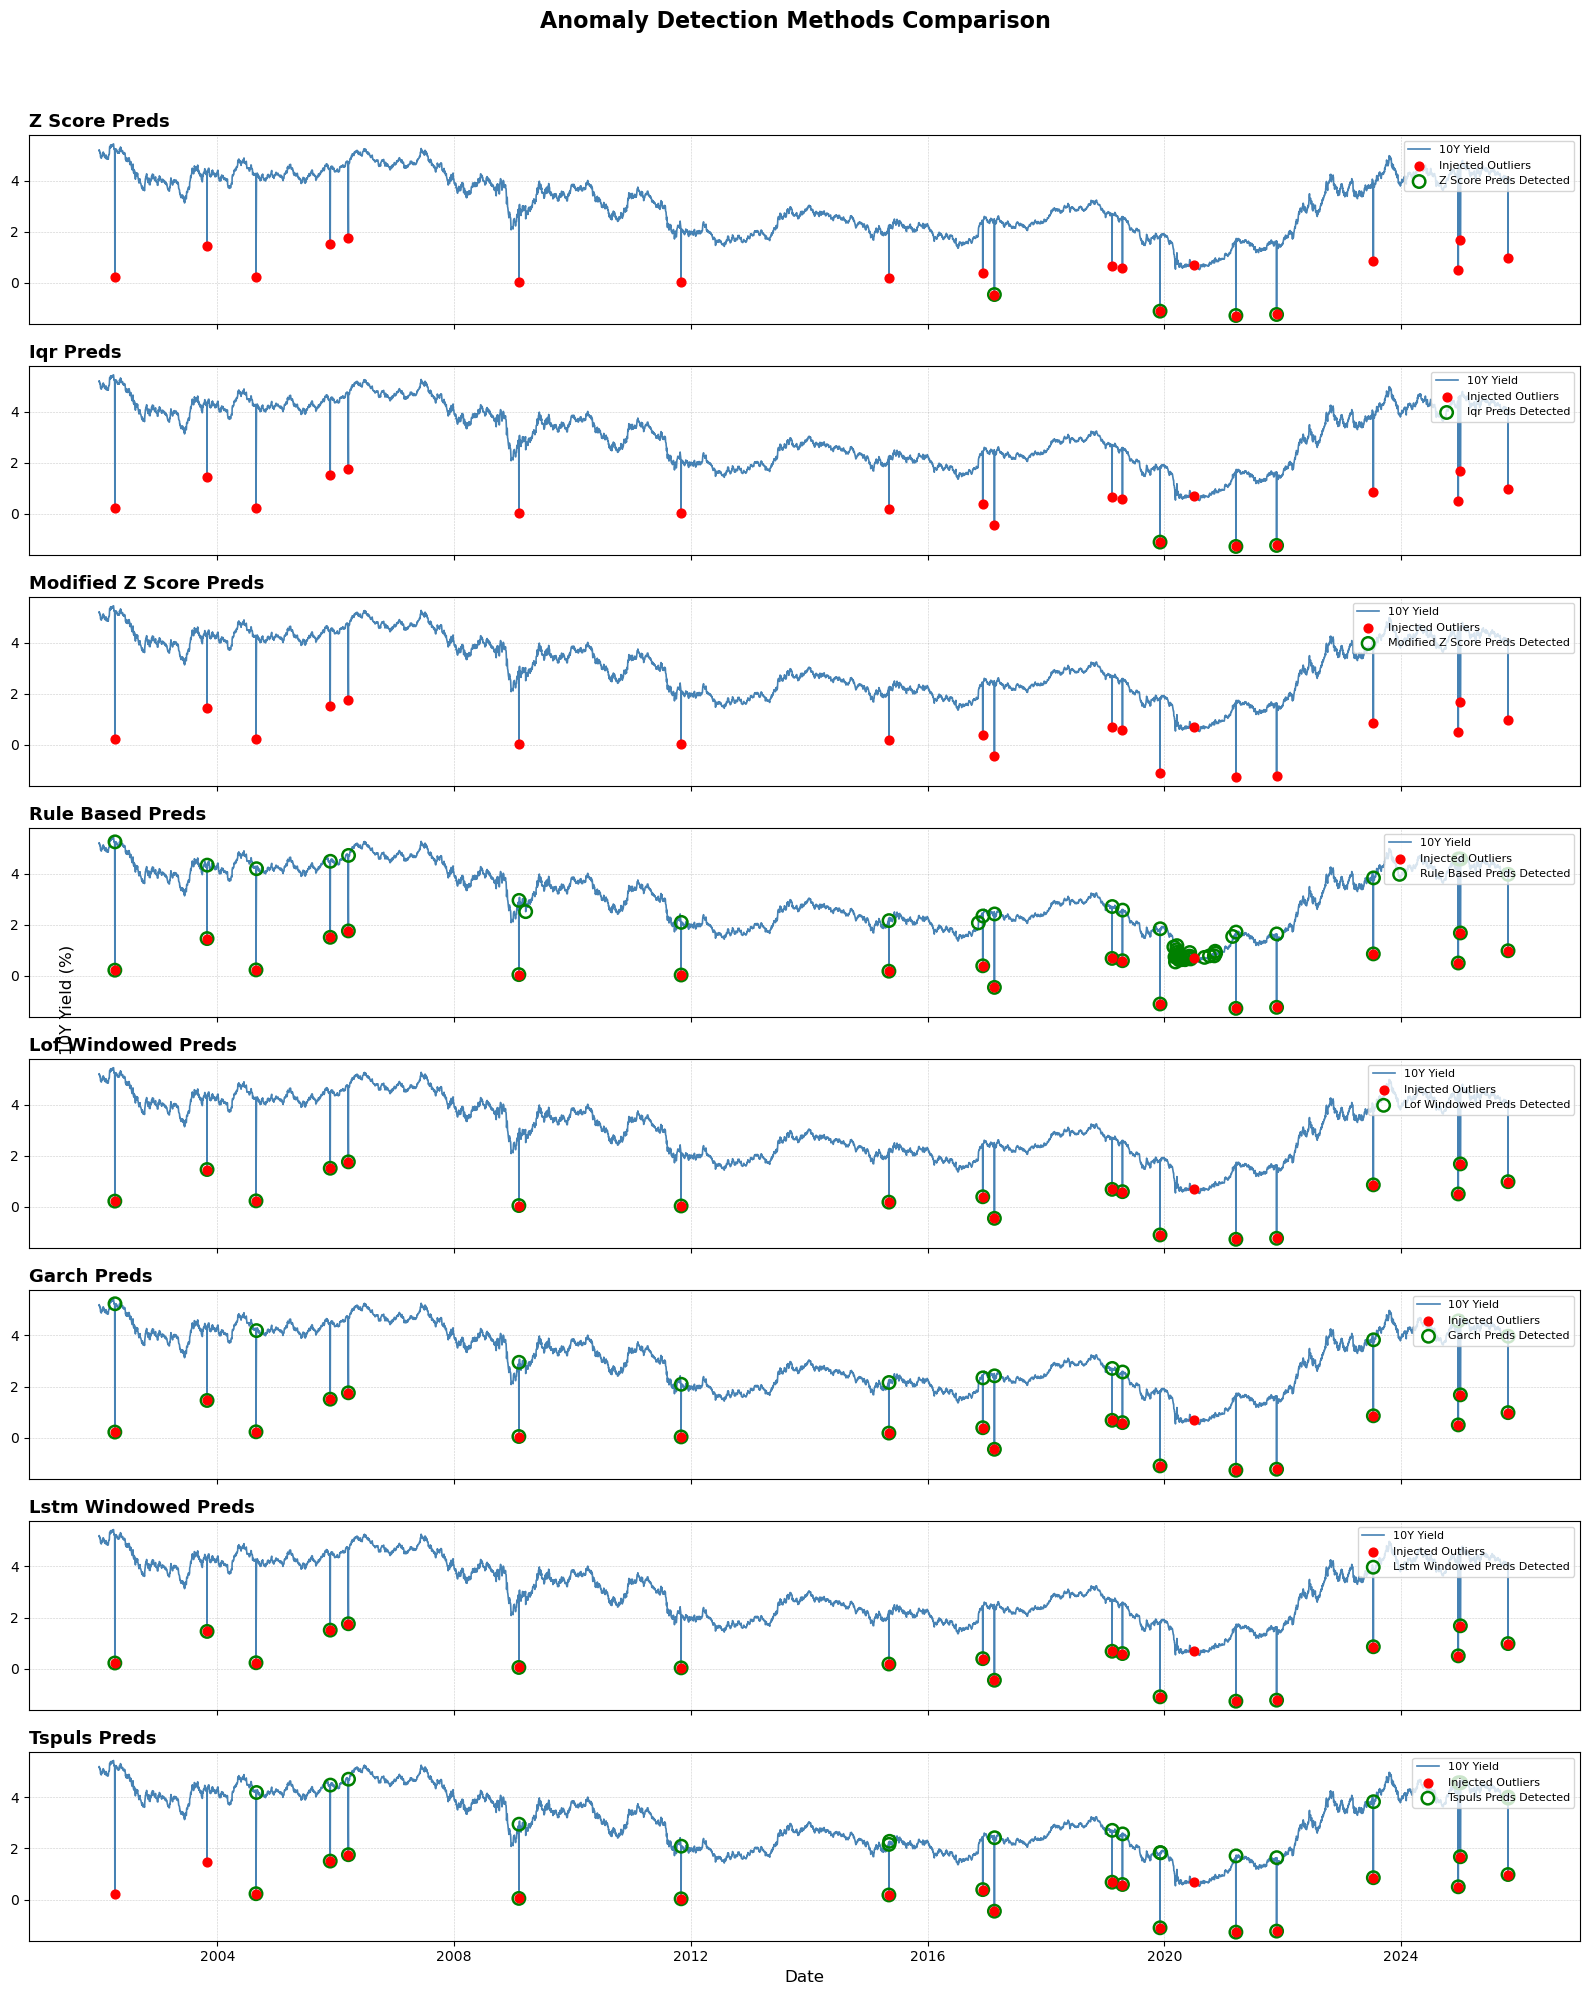

In [56]:
# List of models to visualize (columns in df)
methods = [
    'z_score_preds',
    'iqr_preds',
    'modified_z_score_preds',
    'rule_based_preds',
    'lof_windowed_preds',
    'garch_preds',
    'lstm_windowed_preds',
    'tspuls_preds',
]

# Create subplots
fig, axes = plt.subplots(len(methods), 1, figsize=(16, 2.5 * len(methods)), sharex=True)

for i, method in enumerate(methods):
    ax = axes[i]

    # Plot base line
    ax.plot(df.index, df['10Y'], color='steelblue', linewidth=1.2, label='10Y Yield')

    # Plot injected outliers
    ax.scatter(df.index[df['outlier'] == 1],
               df['10Y'][df['outlier'] == 1],
               color='red', s=40, label='Injected Outliers', zorder=5)

    # Plot model detections
    ax.scatter(df.index[df[method] == 1],
               df['10Y'][df[method] == 1],
               facecolors='none', edgecolors='green', s=80, linewidth=1.8,
               label=f'{method.replace("_", " ").title()} Detected', zorder=4)

    # Styling
    ax.set_title(method.replace("_", " ").title(), fontsize=13, weight='bold', loc='left')
    ax.grid(color='gray', linestyle='--', linewidth=0.4, alpha=0.4)
    ax.legend(fontsize=8, loc='upper right')

# Shared labels
axes[-1].set_xlabel("Date", fontsize=12)
fig.text(0.04, 0.5, "10Y Yield (%)", va='center', rotation='vertical', fontsize=12)

fig.suptitle("Anomaly Detection Methods Comparison", fontsize=16, weight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
